## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox
from odc.ui import select_on_a_map

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides, tidal_tag, model_tides
from intertidal.elevation import (
    load_data,
    ds_to_flat,
    flat_to_ds,
)



## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2017"  # Informed by http://www.bom.gov.au/climate/enso/soi/?
end_date = "2019"  #  Non La Nina/El Nino period
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2012"  # Tide model to use in analysis
tide_model_dir = "/home/jovyan/tide_models_clipped/"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [ ]:
# # Set study area (e.g. tile ID in form 'x143y87')
# study_area = "x100y117"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [ ]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

In [ ]:
# Set study area name for outputs
study_area = "testing"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

In [ ]:
points_gdf = gpd.read_file("data/raw/corr_test.geojson").to_crs("EPSG:3577")
points_gdf["geometry"] = points_gdf.geometry.buffer(500)
geom = Geometry(points_gdf.iloc[0].geometry, crs="EPSG:3577")

## Load data

In [ ]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area="testing",
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    dask_chunks={"x": None, "y": None},
)

print(satellite_ds)

# Load data
satellite_ds.load()

In [ ]:
tides_df = model_tides(
    x=satellite_ds.x.mean(),
    y=satellite_ds.y.mean(),
    time=satellite_ds.time,
    model=[
        "FES2014",
        "TPXO9-atlas-v5",
        "EOT20",
        "HAMTIDE11",
        "GOT4.10",
        "FES2012",
        "TPXO8-atlas-v1",
    ],
    directory=tide_model_dir,
    crs=satellite_ds.odc.crs,
)

In [ ]:
satellite_ds["tide_m"] = (
    tides_df.droplevel(level=["x", "y"])
    .set_index("tide_model", append=True)
    .to_xarray()
    .tide_m.reindex_like(satellite_ds)
    .transpose("tide_model", "time")
)

In [ ]:
_, freq, corr, _ = ds_to_flat(
    satellite_ds,
    ndwi_thresh=0.0,
    min_freq=0.01,
    max_freq=0.99,
    # min_correlation=0.5,
    # valid_mask=topobathy_ds.height_depth > -20,
)

In [ ]:
flat_to_ds(freq, satellite_ds, stacked_dim="z").plot()


In [ ]:
flat_to_ds(corr, satellite_ds, stacked_dim="z").plot(col="tide_model")

In [ ]:
def highlight_max(s):
    is_large = s.nlargest(3).values
    return ["background-color: yellow" if v in is_large else "" for v in s]

corr.drop("spatial_ref").mean(dim="z").to_dataframe(name="tide_m").style.apply(highlight_max)

### Scale test

In [ ]:
points_gdf = gpd.read_file("data/raw/corr_test.geojson").to_crs("EPSG:3577").iloc[314:]
points_gdf.plot()

<Axes: >

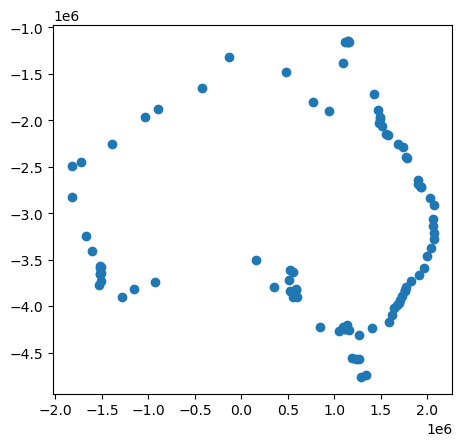

In [4]:
points_gdf = gpd.read_file("gesla_stations_aus.geojson").to_crs("EPSG:3577")
points_gdf = points_gdf.rename({"site_name": "id"}, axis=1)
points_gdf.plot()

In [5]:
points_gdf["geometry"] = points_gdf.geometry.buffer(2500)


In [6]:
def correlation_loop(point_id, geom):
    satellite_ds = load_data(
        dc=dc,
        study_area=point_id,
        geom=geom,
        time_range=(start_date, end_date),
        resolution=resolution,
        crs=crs,
        include_s2=True,
        include_ls=True,
        filter_gqa=filter_gqa,
        dask_chunks={"x": None, "y": None},
    )

    # Load data
    satellite_ds.load()

    # Model tides
    tides_df = model_tides(
        x=satellite_ds.x.mean(),
        y=satellite_ds.y.mean(),
        time=satellite_ds.time,
        model=[
            "FES2014",
            "TPXO9-atlas-v5",
            "EOT20",
            "HAMTIDE11",
            "GOT4.10",
            "FES2012",
            "TPXO8-atlas-v1",
        ],
        directory=tide_model_dir,
        crs=satellite_ds.odc.crs,
    ).rename(
        {
            "TPXO9-atlas-v5": "TPXO9",
            "TPXO8-atlas": "TPXO8",
            "TPXO8-atlas-v1": "TPXO8",
        },
        axis=1,
    )

    # Add to data
    satellite_ds["tide_m"] = (
        tides_df.droplevel(level=["x", "y"])
        .set_index("tide_model", append=True)
        .to_xarray()
        .tide_m.reindex_like(satellite_ds)
        .transpose("tide_model", "time")
    )

    # Calculate corrs
    _, _, corr, _ = ds_to_flat(
        satellite_ds,
        ndwi_thresh=0.0,
        min_freq=0.01,
        max_freq=0.99,
    )
    
    corr_mask = corr.max(dim="tide_model") >= 0.2
    corr = corr.where(corr_mask)

    out_df = (
        corr.drop("spatial_ref")
        .mean(dim="z")
        .to_dataframe(name="tide_m")
        .assign(point_id=point_id)
        .set_index("point_id", append=True)
    )
    
    # Add percent valid intertidal pixels analysed
    out_df["valid_perc"] = corr_mask.mean(dim="z").item()
    
    return out_df

In [7]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

out_list = []

for i, row in points_gdf.iterrows():
    
    point_id = row.id
    print(f"{point_id}, {i}/{len(points_gdf.index)}")
    geom = Geometry(row.geometry, crs="EPSG:3577")       
        
    output_df = correlation_loop(point_id, geom)
    output_df["x"] = row.geometry.centroid.x
    output_df["y"] = row.geometry.centroid.y
    
    out_list.append(output_df)
    
    client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34851,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:34837,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/46837/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:46549,


Brunswick_Heads, 0/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Reducing analysed pixels from 251001 to 4032 (1.61%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:05:18,074 - distributed.nanny - WARNING - Restarting worker


Coffs_Harbour, 1/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Reducing analysed pixels from 251001 to 3759 (1.50%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:06:14,456 - distributed.nanny - WARNING - Restarting worker


Port_Macquarie, 2/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 3866 (1.54%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:07:13,396 - distributed.nanny - WARNING - Restarting worker


Forster, 3/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 4328 (1.72%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:08:08,428 - distributed.nanny - WARNING - Restarting worker


Patonga, 4/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 2866 (1.14%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:09:22,055 - distributed.nanny - WARNING - Restarting worker


Sydney_Port_Jackson, 5/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 2031 (0.81%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:10:47,099 - distributed.nanny - WARNING - Restarting worker


Crookhaven_Heads, 6/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 6504 (2.59%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:12:10,623 - distributed.nanny - WARNING - Restarting worker


Batemans_Bay_Princess_Jetty, 7/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 4330 (1.73%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:13:31,454 - distributed.nanny - WARNING - Restarting worker


Jervis_Bay, 8/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 1319 (0.53%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:15:06,084 - distributed.nanny - WARNING - Restarting worker


Ulladulla, 9/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 3582 (1.43%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:16:36,653 - distributed.nanny - WARNING - Restarting worker


Bermagui, 10/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 2845 (1.13%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:17:52,014 - distributed.nanny - WARNING - Restarting worker


Ince_Point, 11/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 5587 (2.23%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:18:56,398 - distributed.nanny - WARNING - Restarting worker


Thursday_Island, 12/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 4289 (1.71%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:20:01,271 - distributed.nanny - WARNING - Restarting worker


Nardana_Patches, 13/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Reducing analysed pixels from 251001 to 905 (0.36%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:20:49,527 - distributed.nanny - WARNING - Restarting worker


Turtle_Head, 14/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Reducing analysed pixels from 251001 to 13455 (5.36%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:21:40,899 - distributed.nanny - WARNING - Restarting worker


Goods_Island, 15/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Reducing analysed pixels from 251001 to 4829 (1.92%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:22:33,487 - distributed.nanny - WARNING - Restarting worker


Booby_Island, 16/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Reducing analysed pixels from 251001 to 103 (0.04%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:23:17,327 - distributed.nanny - WARNING - Restarting worker


Cairns, 17/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Reducing analysed pixels from 251001 to 10106 (4.03%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:24:44,902 - distributed.nanny - WARNING - Restarting worker


Mourilyan_Harbour, 18/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 16828 (6.70%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:25:47,808 - distributed.nanny - WARNING - Restarting worker


Clump_Point, 19/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 7946 (3.17%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:26:47,873 - distributed.nanny - WARNING - Restarting worker


Lucinda_Offshore, 20/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Reducing analysed pixels from 251001 to 1 (0.00%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:27:27,793 - distributed.nanny - WARNING - Restarting worker


Townsville, 21/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Reducing analysed pixels from 251001 to 5329 (2.12%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:28:31,598 - distributed.nanny - WARNING - Restarting worker


Cape_Ferguson, 22/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 18003 (7.17%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:29:39,950 - distributed.nanny - WARNING - Restarting worker


Bowen, 23/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 20520 (8.18%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:30:53,868 - distributed.nanny - WARNING - Restarting worker


Shute_Harbour, 24/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Reducing analysed pixels from 251001 to 8554 (3.41%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:31:45,608 - distributed.nanny - WARNING - Restarting worker


Mackay_Outer_Harbour, 25/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 6121 (2.44%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:33:12,080 - distributed.nanny - WARNING - Restarting worker


Hay_Point, 26/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 6339 (2.53%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:34:14,178 - distributed.nanny - WARNING - Restarting worker


Rosslyn_Bay, 27/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 7129 (2.84%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:35:23,697 - distributed.nanny - WARNING - Restarting worker


Port_Alma, 28/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 117640 (46.87%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:36:55,061 - distributed.nanny - WARNING - Restarting worker


Gladstone, 29/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 251001 to 7650 (3.05%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:37:57,181 - distributed.nanny - WARNING - Restarting worker


Bundaberg_Burnett_Heads, 30/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 7113 (2.83%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:38:50,747 - distributed.nanny - WARNING - Restarting worker


Urangan, 31/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 251001 to 12062 (4.81%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:40:13,882 - distributed.nanny - WARNING - Restarting worker


Mooloolaba, 32/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 3369 (1.34%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:41:41,918 - distributed.nanny - WARNING - Restarting worker


Brisbane_Bar, 33/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Reducing analysed pixels from 251001 to 13157 (5.24%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:42:46,057 - distributed.nanny - WARNING - Restarting worker


Gold_Coast_Southport, 34/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 7559 (3.01%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:43:45,112 - distributed.nanny - WARNING - Restarting worker


Yamba, 35/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 7346 (2.93%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:44:50,560 - distributed.nanny - WARNING - Restarting worker


Newcastle, 36/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 250500 to 2733 (1.09%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:46:03,462 - distributed.nanny - WARNING - Restarting worker


Sydney_Fort_Denison, 37/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 630 (0.25%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:47:31,593 - distributed.nanny - WARNING - Restarting worker


Botany_Bay, 38/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Reducing analysed pixels from 251001 to 1888 (0.75%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:48:48,366 - distributed.nanny - WARNING - Restarting worker


Port_Kembla, 39/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 2405 (0.96%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:50:39,584 - distributed.nanny - WARNING - Restarting worker


Eden, 40/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Reducing analysed pixels from 251001 to 1332 (0.53%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:52:08,083 - distributed.nanny - WARNING - Restarting worker


Lakes_Entrance_Inner_Bullock_Island, 41/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 1027 (0.41%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:53:29,819 - distributed.nanny - WARNING - Restarting worker


Port_Welshpool_Pier, 42/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 251001 to 36122 (14.39%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:54:33,757 - distributed.nanny - WARNING - Restarting worker


Western_Port_Stony_Point, 43/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Reducing analysed pixels from 251001 to 33261 (13.25%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:56:19,102 - distributed.nanny - WARNING - Restarting worker


Hovell_Pile, 44/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Reducing analysed pixels from 250500 to 0 (0.00%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:58:10,235 - distributed.nanny - WARNING - Restarting worker


Point_Lonsdale, 45/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 2747 (1.09%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-29 23:59:58,645 - distributed.nanny - WARNING - Restarting worker


Queenscliff, 46/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 20659 (8.23%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:01:48,812 - distributed.nanny - WARNING - Restarting worker


West_Channel_Pile, 47/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Reducing analysed pixels from 251001 to 0 (0.00%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:03:57,298 - distributed.nanny - WARNING - Restarting worker


Point_Richards_Corio_Bay, 48/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Reducing analysed pixels from 251001 to 726 (0.29%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:05:42,228 - distributed.nanny - WARNING - Restarting worker


Geelong, 49/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 995 (0.40%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:06:56,482 - distributed.nanny - WARNING - Restarting worker


Melbourne_Williamstown, 50/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 1546 (0.62%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:08:12,012 - distributed.nanny - WARNING - Restarting worker


Lorne, 51/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Reducing analysed pixels from 251001 to 2971 (1.18%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:09:18,967 - distributed.nanny - WARNING - Restarting worker


Burnie, 52/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 3607 (1.44%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:11:00,592 - distributed.nanny - WARNING - Restarting worker


Devonport, 53/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 6476 (2.58%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:12:15,513 - distributed.nanny - WARNING - Restarting worker


Low_Head, 54/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Reducing analysed pixels from 251001 to 19442 (7.75%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:14:05,442 - distributed.nanny - WARNING - Restarting worker


Spring_Bay, 55/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Reducing analysed pixels from 251001 to 285 (0.11%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:15:28,512 - distributed.nanny - WARNING - Restarting worker


Hobart, 56/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 251001 to 341 (0.14%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:16:27,113 - distributed.nanny - WARNING - Restarting worker


Portland, 57/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 373 (0.15%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:17:43,594 - distributed.nanny - WARNING - Restarting worker


Victor_Harbor, 58/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 251001 to 1707 (0.68%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:18:46,361 - distributed.nanny - WARNING - Restarting worker


Cape_Jervis, 59/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 656 (0.26%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:20:21,488 - distributed.nanny - WARNING - Restarting worker


Port_Adelaide_Outer_Harbor, 60/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Reducing analysed pixels from 251001 to 16001 (6.37%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:21:38,972 - distributed.nanny - WARNING - Restarting worker


Port_Adelaide_Inner_Harbor, 61/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 5019 (2.00%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:23:00,259 - distributed.nanny - WARNING - Restarting worker


Port_Giles, 62/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Reducing analysed pixels from 250500 to 5534 (2.21%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:24:13,433 - distributed.nanny - WARNING - Restarting worker


Wallaroo, 63/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Reducing analysed pixels from 251001 to 5005 (1.99%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:25:08,855 - distributed.nanny - WARNING - Restarting worker


Port_Pirie, 64/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 4038 (1.61%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:26:09,409 - distributed.nanny - WARNING - Restarting worker


Whyalla, 65/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 1460 (0.58%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:27:01,455 - distributed.nanny - WARNING - Restarting worker


Port_Lincoln, 66/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 251001 to 2209 (0.88%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:28:16,158 - distributed.nanny - WARNING - Restarting worker


Thevenard, 67/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 3736 (1.49%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:29:02,259 - distributed.nanny - WARNING - Restarting worker


Esperance, 68/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 1237 (0.49%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:30:14,743 - distributed.nanny - WARNING - Restarting worker


Albany, 69/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 250500 to 4236 (1.69%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:31:25,197 - distributed.nanny - WARNING - Restarting worker


Bunbury, 70/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 9785 (3.90%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:32:33,386 - distributed.nanny - WARNING - Restarting worker


Fremantle, 71/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 4641 (1.85%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:33:44,809 - distributed.nanny - WARNING - Restarting worker


Hillarys, 72/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Reducing analysed pixels from 251001 to 1498 (0.60%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:34:46,851 - distributed.nanny - WARNING - Restarting worker


Perth_Barrack_Street_Jetty, 73/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 9305 (3.71%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:36:03,969 - distributed.nanny - WARNING - Restarting worker


Geraldton, 74/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 3701 (1.47%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:36:54,939 - distributed.nanny - WARNING - Restarting worker


Carnarvon, 75/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 52912 (21.08%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:38:11,503 - distributed.nanny - WARNING - Restarting worker


Exmouth, 76/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Reducing analysed pixels from 251001 to 3519 (1.40%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:39:41,374 - distributed.nanny - WARNING - Restarting worker


Onslow_Beadon_Creek, 77/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.90s/it]


Reducing analysed pixels from 251001 to 15507 (6.18%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:41:00,385 - distributed.nanny - WARNING - Restarting worker


Port_Hedland, 78/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 39039 (15.55%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:42:12,908 - distributed.nanny - WARNING - Restarting worker


Broome, 79/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Reducing analysed pixels from 251001 to 16749 (6.67%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:43:19,058 - distributed.nanny - WARNING - Restarting worker


Wyndham, 80/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 8357 (3.33%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:44:53,318 - distributed.nanny - WARNING - Restarting worker


Darwin, 81/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Reducing analysed pixels from 251001 to 18169 (7.24%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:45:55,844 - distributed.nanny - WARNING - Restarting worker


Milner_Bay_Groote_Eylandt, 82/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Reducing analysed pixels from 251001 to 1560 (0.62%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:47:01,521 - distributed.nanny - WARNING - Restarting worker


Karumba, 83/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 4018 (1.60%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:48:05,853 - distributed.nanny - WARNING - Restarting worker


Weipa_Humbug_Point, 84/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 7839 (3.12%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:49:29,401 - distributed.nanny - WARNING - Restarting worker


Bremer_Bay, 85/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 366 (0.15%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:50:41,779 - distributed.nanny - WARNING - Restarting worker


Busselton_Port_Geographe, 86/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 2681 (1.07%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:51:50,792 - distributed.nanny - WARNING - Restarting worker


Cape_Bouvard, 87/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Reducing analysed pixels from 251001 to 1510 (0.60%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:53:05,184 - distributed.nanny - WARNING - Restarting worker


Caddadup, 88/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Reducing analysed pixels from 251001 to 3144 (1.25%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:54:22,802 - distributed.nanny - WARNING - Restarting worker


Derby, 89/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 134417 (53.55%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:55:34,105 - distributed.nanny - WARNING - Restarting worker


Cardwell, 90/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 9791 (3.90%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:56:32,755 - distributed.nanny - WARNING - Restarting worker


Fishermans_Landing, 91/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Reducing analysed pixels from 251001 to 32547 (12.97%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:57:39,964 - distributed.nanny - WARNING - Restarting worker


South_Trees, 92/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Reducing analysed pixels from 251001 to 29960 (11.94%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 00:58:43,354 - distributed.nanny - WARNING - Restarting worker


Cooktown, 93/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Reducing analysed pixels from 250500 to 6286 (2.51%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 01:00:23,877 - distributed.nanny - WARNING - Restarting worker


Mornington_Island, 94/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


Reducing analysed pixels from 251001 to 16954 (6.75%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 01:03:19,500 - distributed.nanny - WARNING - Restarting worker


Jurien_Bay, 95/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Reducing analysed pixels from 251001 to 656 (0.26%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 01:06:23,967 - distributed.nanny - WARNING - Restarting worker


Mandurah_Ocean_Marina, 96/97
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Reducing analysed pixels from 251001 to 4041 (1.61%)


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-10-30 01:07:45,938 - distributed.nanny - WARNING - Restarting worker


In [9]:
combined_df = (
    pd.concat(out_list)
    .set_index(["x", "y", "valid_perc"], append=True)
    .unstack("tide_model")["tide_m"]
    .reset_index(["x", "y", "valid_perc"])
)
combined_df

tide_model,x,y,valid_perc,EOT20,FES2012,FES2014,GOT4.10,HAMTIDE11,TPXO8-atlas-v1,TPXO9-atlas-v5
point_id,,,,,,,,,,
Albany,-1.281223e+06,-3.896680e+06,0.033691,0.304455,0.299061,0.295704,0.293604,0.294369,0.295050,0.297660
Batemans_Bay_Princess_Jetty,1.638107e+06,-4.017208e+06,0.084537,0.277347,0.272401,0.276640,0.275110,0.273281,0.276493,0.276049
Bermagui,1.617302e+06,-4.095083e+06,0.022794,0.312666,0.309344,0.312524,0.312484,0.309224,0.312005,0.311590
Booby_Island,1.111173e+06,-1.156245e+06,0.045778,0.238797,0.246256,0.243971,0.248112,0.237981,0.245071,0.242584
Botany_Bay,1.760327e+06,-3.839884e+06,0.022912,0.383742,0.374294,0.377909,0.378690,0.376488,0.375078,0.377183
...,...,...,...,...,...,...,...,...,...,...
West_Channel_Pile,1.123959e+06,-4.232040e+06,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Western_Port_Stony_Point,1.162976e+06,-4.255891e+06,0.191894,0.278939,0.306580,0.271924,0.303871,0.306085,0.312077,0.324269
Whyalla,5.184426e+05,-3.611906e+06,0.029098,0.175911,0.140933,0.185623,0.128392,0.201851,0.171530,0.186947


In [10]:
combined_df["min_corr"] = combined_df.iloc[:, 3:10].min(axis=1)
combined_df["max_corr"] = combined_df.iloc[:, 3:10].max(axis=1)
combined_df["ave_corr"] = combined_df.iloc[:, 3:10].mean(axis=1)
combined_df["top_model"] = combined_df.iloc[:, 3:10].idxmax(axis=1)
combined_df["worst_model"] = combined_df.iloc[:, 3:10].idxmin(axis=1)

In [11]:
gpd.GeoDataFrame(data=combined_df, geometry=gpd.points_from_xy(combined_df.x, combined_df.y, crs="EPSG:3577")).to_crs("EPSG:4326").to_file("corr_results_gesla_v3.geojson")